In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
import numpy as np
import pandas as pd
import umap

from datetime import datetime
from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(20,10),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [11]:
fname = "data/cleaned_SA.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,ASD,HR,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,TYPICAL,LR,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,TYPICAL,LR,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,TYPICAL,LR,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [12]:
raw_data.shape

(325, 335)

In [13]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
labels = raw_data[label_cols].copy()

In [14]:
labels["Risk"][labels["Risk"]=="HR"].value_counts()

HR    214
Name: Risk, dtype: int64

In [15]:
labels["ASD_DX_group"][labels["Risk"]=="HR"].value_counts()

TYPICAL            149
ASD                 39
ATYPICAL_ADOS       17
ATYPICAL_MULLEN      9
Name: ASD_DX_group, dtype: int64

In [16]:
LR = labels["Risk"]=="LR"
typical = labels["ASD_DX_group"]=="TYPICAL"
ASD = labels["ASD_DX_group"]=="ASD"
LR_typical = labels[LR & typical]

In [17]:
HR = labels["Risk"]=="HR"
HR_nontypical = labels[HR & ~typical]

In [18]:
analysis_labels = pd.concat((LR_typical, HR_nontypical))
analysis_labels["Risk"].value_counts()

LR    99
HR    65
Name: Risk, dtype: int64

In [19]:
enc = OrdinalEncoder()
enc.fit(analysis_labels)
enc_labels = enc.transform(analysis_labels)
enc.categories_

[array(['ASD', 'ATYPICAL_ADOS', 'ATYPICAL_MULLEN', 'TYPICAL'], dtype=object),
 array(['HR', 'LR'], dtype=object)]

In [49]:
risk_labels = pd.Series(enc_labels[:,1], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.2)

print(train_data.shape)
train_labels.value_counts()

(131, 333)


1    79
0    52
dtype: int64

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=20,
                                           verbose=2, mode='max', baseline=None, restore_best_weights=True)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)

In [78]:
def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    from keras.constraints import max_norm
    keras.backend.clear_session()
    
    tf.random.set_random_seed(RANDOM_STATE)
    reg_scale = 0.01 # For L1 Reg
    my_reg = regularizers.l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)

    dnn.add(Dense(units = 64, activation=activation, input_dim = num_features,
                  kernel_initializer=he_init,  kernel_regularizer=my_reg))
    dnn.add(keras.layers.Dropout(0.2)),
    dnn.add(Dense(units = 64, activation=activation,
                  kernel_initializer=he_init,  kernel_regularizer=my_reg))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init,  kernel_regularizer=my_reg)) # 5 labels -> logits for now
    
#     SGD=keras.optimizers.SGD(lr=0.001)
    NSGD = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [79]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                21376     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 25,601
Trainable params: 25,601
Non-trainable params: 0
_________________________________________________________________


In [41]:
time = datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir='./logs/{}_dp_02_l2_relu_all-hlr'.format(time),
                          update_freq="epoch", write_graph=False)

In [42]:
%%time
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=10000, batch_size=X_train.shape[0], verbose=0, callbacks=[tensorboard])

CPU times: user 39.2 s, sys: 8.77 s, total: 47.9 s
Wall time: 22.6 s


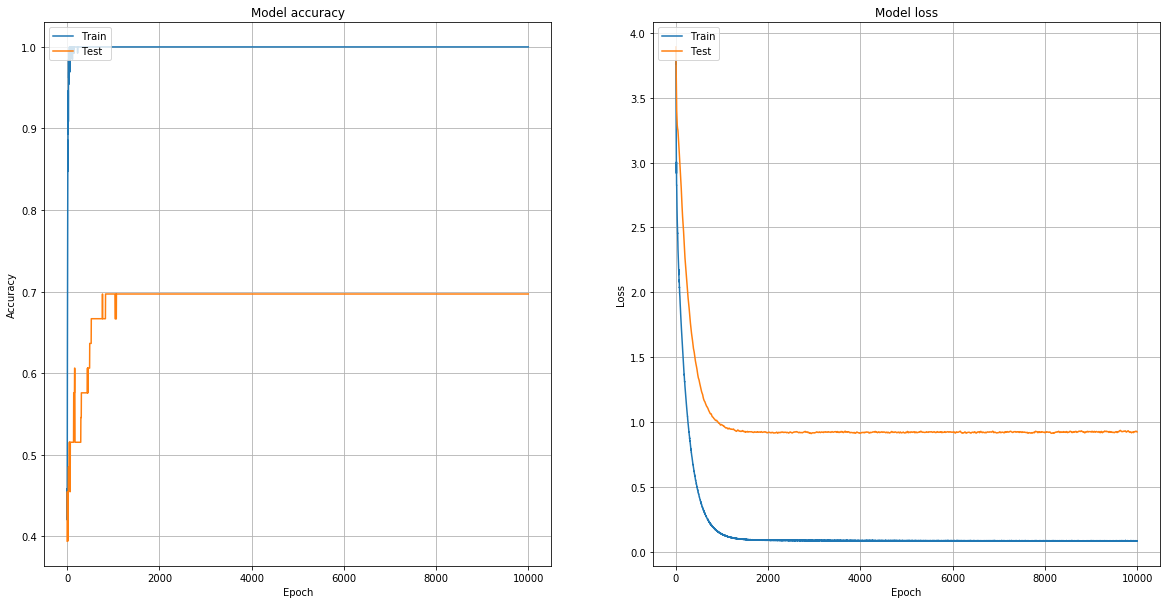

33/33 [==============================] - 0s 80us/step
Loss:0.923, Acc:0.6970


In [43]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

Confusion matrix, without normalization
[[0.61538462 0.38461538]
 [0.25       0.75      ]]
Overall Accuracy: 0.6970


(<matplotlib.axes._subplots.AxesSubplot at 0x1a3e3c7eb8>, array([[ 8,  5],
        [ 5, 15]]))

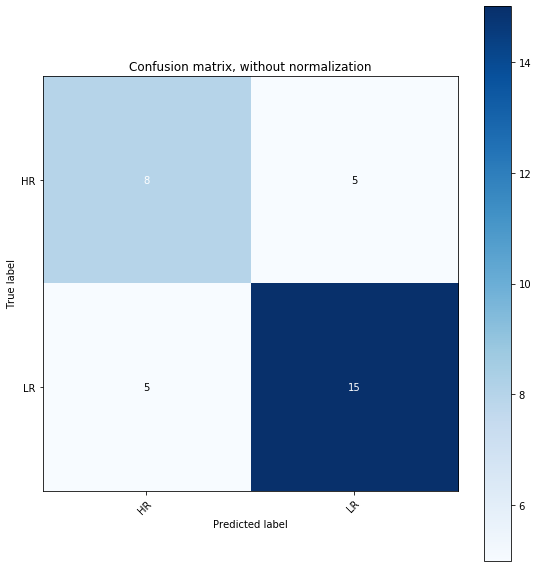

In [44]:
y_pred = np.round(np.ravel(dnn.predict(X_valid)))
plot_confusion_matrix(np.ravel(y_valid), y_pred, enc.categories_[1])

In [45]:
from sklearn.metrics import precision_score, make_scorer
prec_scorer = make_scorer(precision_score, pos_label=0)

precision_score(y_true=np.ravel(y_valid), y_pred=y_pred, pos_label=0)

0.6153846153846154

## Calculate LRP

In [50]:
val_samples = analysis_labels.loc[test_labels.index]
val_samples["DNN Pred"] = y_pred
val_samples[val_samples["Risk"]=="HR"]

,ASD_DX_group,Risk,DNN Pred
CandID,,,
526558,ASD,HR,1.0
950194,ASD,HR,1.0
321541,ASD,HR,0.0
857317,ASD,HR,0.0
751794,ASD,HR,1.0
677040,ATYPICAL_MULLEN,HR,0.0
402809,ASD,HR,0.0
389521,ASD,HR,0.0
456823,ASD,HR,0.0


In [51]:
_correct = np.logical_and(y_pred == np.ravel(y_valid) , (val_samples["Risk"]=="HR").values)
_labels = val_samples[_correct]["ASD_DX_group"].values

In [52]:
correct_HR_samples = X_valid[np.logical_and(y_pred == np.ravel(y_valid) , (val_samples["Risk"]=="HR").values)]

In [53]:
import innvestigate
import innvestigate.utils as iutils

analyzer_type = "pattern.attribution"
analyzer_kwargs = {
    "pattern.attribution":
        {"pattern_type":"relu"},
    "lrp.epsilon":
        {"epsilon":1e-3}
 }

model_wo_softmax = dnn
# model_wo_softmax = iutils.keras.graph.model_wo_softmax(dnn)

analyzer = innvestigate.create_analyzer(analyzer_type, model_wo_softmax,
                                        **analyzer_kwargs[analyzer_type])
analyzer.fit(X_train, batch_size=20, verbose=1, disable_no_training_warning=True)

Epoch 1/1
7/7 [==============================] - 0s 27ms/step - loss: 3.1432 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000


In [54]:
lrp = analyzer.analyze(correct_HR_samples)
# pd.DataFrame(relevance_results)
lrp.shape

(8, 333)

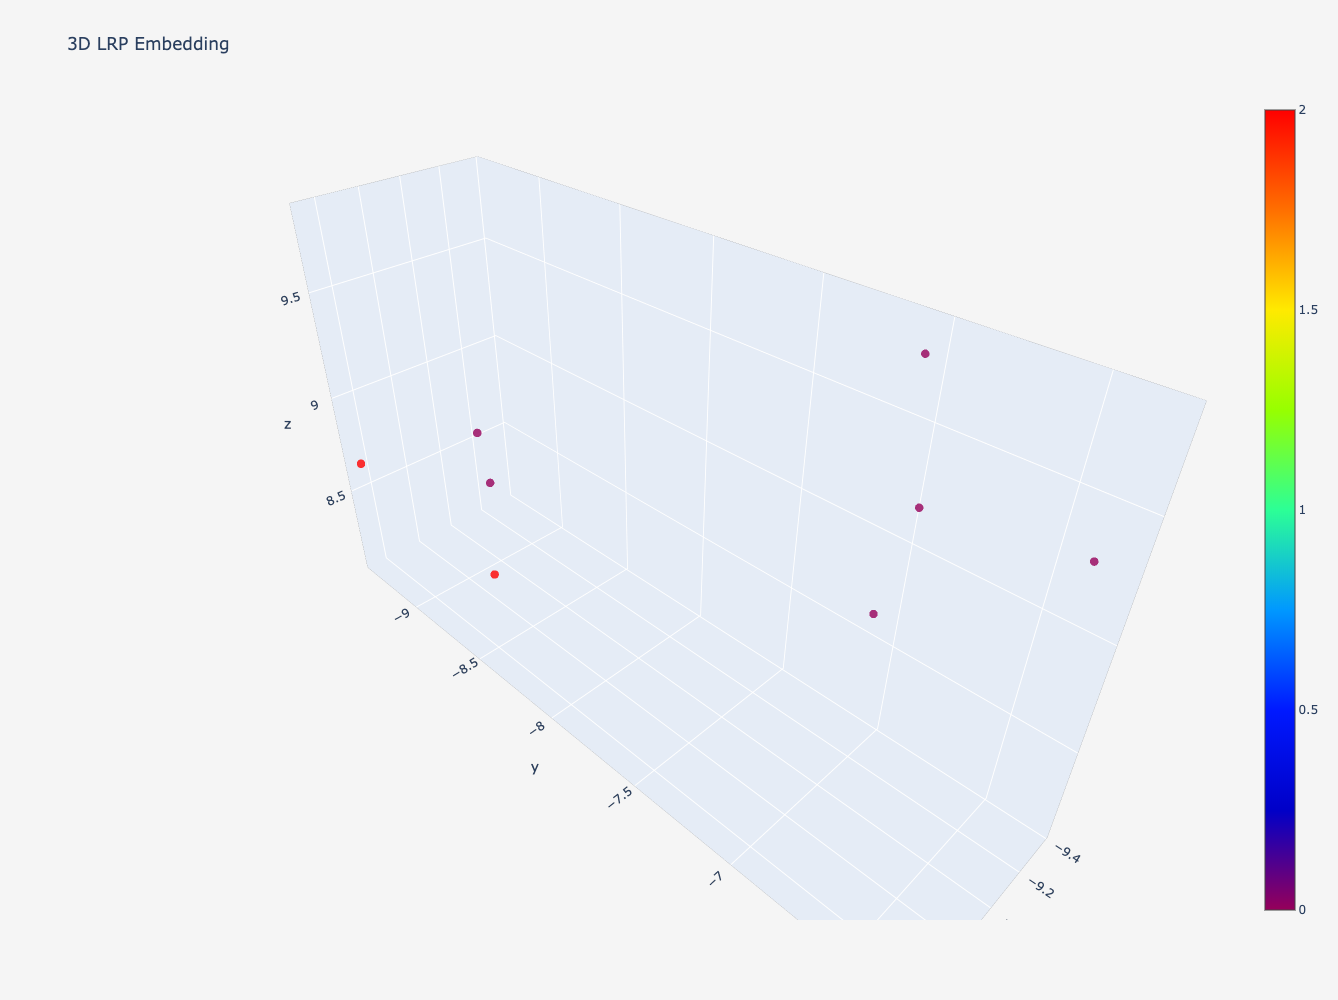

In [59]:
from sklearn.preprocessing import MinMaxScaler
from helper import plot_3d_lrp

reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=6,
                    min_dist=0)

reducer_pipeline = Pipeline([
            ("umap", reducer),
#             ("scaler",  MinMaxScaler())
])

reducer_pipeline.fit(lrp)
embeddings = reducer_pipeline.transform(lrp)
plot_3d_lrp(embeddings, colors= enc.transform(_labels.reshape(-1,1))[:,0], labels=_labels )

### Cross Validating

In [80]:
# Separating a hold out set that will be used for validation of the pipeline
# train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.01)
train_data, train_labels, test_data, test_labels = data, risk_labels, [], []

In [81]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

In [82]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False, analyzer_type="pattern.attribution")

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.463, Acc:1.0000
Prediction Accuracy
17/17 [==============================] - 0s 3ms/step
Scores on data set: loss=1.271 accuracy=0.5882
Fold Correct: 10
Epoch 1/1
8/8 [==============================] - 0s 25ms/step - loss: 3.8834 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000
Running worker: 1
Fold: 1 -> Loss:0.463, Acc:1.0000
Prediction Accuracy
17/17 [==============================] - 0s 35us/step
Scores on data set: loss=1.845 accuracy=0.5294
Fold Correct: 9
Epoch 1/1
8/8 [==============================] - 0s 30ms/step - loss: 3.8820 - broadcast_4_loss: 1.0000 - broadcast_5_loss: 1.0000 - broadcast_6_loss: 1.0000
Running worker: 2
Fold: 2 -> Loss:0.461, Acc:1.0000
Prediction Accuracy
17/17 [==============================] - 0s 38us/step
Scores on data set: loss=1.286 accuracy=0.5882
Fold Correct: 10
Epoch 1/1
8/8 [==============================] - 0s 34ms/step - loss: 3.8825 - broadc

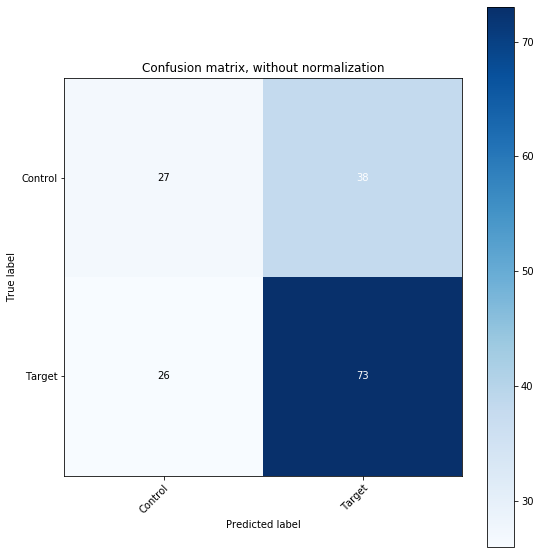

In [83]:
cm = pipeline.train_model(batch_size=int(0.9*train_data.shape[0]), epochs=5000, cross_validation=True, parallel=False, verbose=0)

In [84]:
cm[0][0]

27

In [177]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = 20,
                    n_neighbors=6,
                    min_dist=0)

pipeline.reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
        ])

_, correct_pred_idxs = pipeline.train_clusterer(plot=False, class_label=0, clip=True)
print("Clusters Found:", max(pipeline.clusterer.labels_)+1)

LRP Shape:  (27, 333)
Cluster Search Space: range(3, 9)
Minimum Size:
Clusters                  (7, 7)
Noise                     (3, 3)
Halkidi                   (3, 3)
Halkidi-Filtered Noise    (3, 3)
dtype: object
Clusters Found: 2


In [178]:
np.max(pipeline.training_lrp)

0.0031662858

In [179]:
reindexed_labels = train_labels.iloc[pipeline.testing_idxs]
correct_idxs = pipeline.correct_preds_bool_arr
reindexed_labels.shape

(164,)

In [180]:
_correct=analysis_labels.loc[reindexed_labels[correct_idxs].index]
correct_HR = _correct[_correct["Risk"]=="HR"]
# enc.transform(correct_HR)[:,0]

In [181]:
plot_3d_lrp(pipeline.training_lrp, colors=pipeline.clusterer.labels_, labels=correct_HR["ASD_DX_group"])

In [106]:
correct_HR["DNN Clusters"] = pipeline.clusterer.labels_
correct_HR.columns

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Index(['ASD_DX_group', 'Risk', 'DNN Clusters'], dtype='object')

In [107]:
for cluster,samples in correct_HR.groupby(by=["DNN Clusters"]):
    print("Cluster", cluster)
    print(samples.index)

# for cluster in range(0, max(pipeline.clusterer.labels_)):
#     print(i)

# pipeline.training_lrp[]

Cluster 0
Int64Index([983222, 174982, 490878, 963368, 930203, 638999, 443584], dtype='int64', name='CandID')
Cluster 1
Int64Index([792210, 550654, 155712, 336576, 516442, 553295, 569748, 812857,
            973338, 121007, 549587, 783552, 809318, 456823, 447346, 677040,
            919979, 321541, 402809, 751794],
           dtype='int64', name='CandID')


In [108]:
orig_labels = analysis_labels.loc[reindexed_labels.index]
orig_labels["DNN Pred"] = pipeline.predictions
orig_HR = orig_labels[orig_labels["Risk"]=="HR"]

In [109]:
orig_HR.head()

,ASD_DX_group,Risk,DNN Pred
CandID,,,
107524,ASD,HR,1.0
172993,ASD,HR,1.0
364612,ASD,HR,1.0
792210,ATYPICAL_ADOS,HR,0.0
916595,ASD,HR,1.0


In [110]:
_counts=[]
names=[]
for name, subgroup in orig_HR.groupby(by="ASD_DX_group"):
    names.append(name)
    _cnt = subgroup["DNN Pred"].value_counts()
    _counts.append([_cnt[0.0], _cnt[1.0]])
#     print(name, subgroup["DNN Pred"].value_counts(), sep="\n")

dnn_predictions = pd.DataFrame(_counts, columns=["Correct","Incorrect"], index=names)
dnn_predictions

,Correct,Incorrect
ASD,18,21
ATYPICAL_ADOS,5,12
ATYPICAL_MULLEN,4,5


In [111]:
norm_pred = dnn_predictions.div(dnn_predictions.sum(axis=1), axis="index")

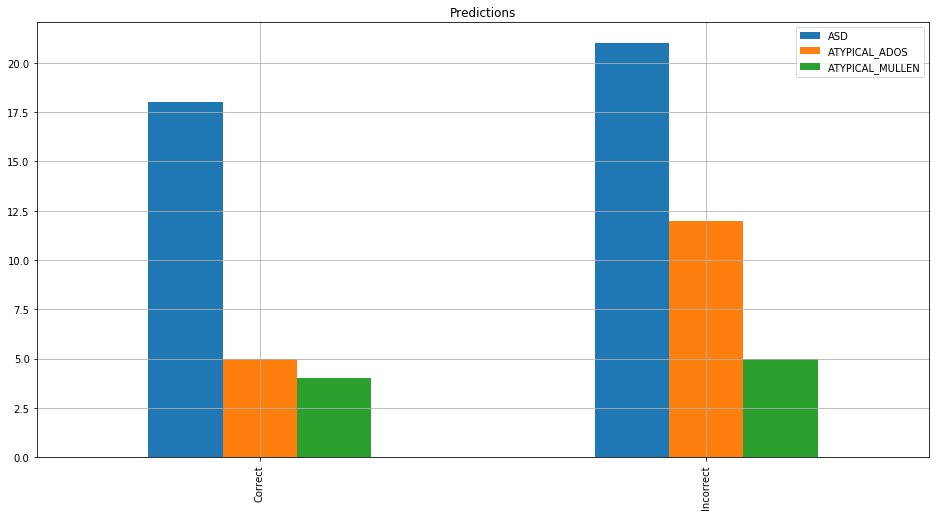

In [112]:
dnn_predictions.T.plot(kind="bar", figsize=(16,8), grid=True, title="Predictions")

# Performing Feature Reduction

## Getting correctly predictied samples form target class

In [114]:
subcluster_labels = range(0,max(pipeline.clusterer.labels_)+1)

# Get testing samples from cross validation
reindexer = pipeline.testing_idxs

# That were correctly predicted
correct_preds = pipeline.correct_preds_bool_arr

# Separating Control from Target
target_samples  = train_labels.iloc[reindexer][correct_preds] == pipeline.target_class
control_samples = ~target_samples

target_class_features = train_data.iloc[reindexer][correct_preds][target_samples]
target_class_labels   = train_labels.iloc[reindexer][correct_preds][target_samples]
target_class_features.head()

,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,ROI09,ROI10,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
792210,544.747375,282.156830,123.827805,114.922913,484.121674,582.419495,36.052818,157.572250,40.588688,47.223228,...,24.159775,112.068031,20.559933,214.147858,32.863773,1.123717,182.320999,30.593807,33.158493,13.562756
983222,933.468018,271.414246,148.111389,231.123978,479.046448,742.643127,48.516346,193.973755,76.143867,45.378262,...,102.482948,145.021393,27.981968,322.337891,185.100433,0.629175,214.278763,34.624138,52.946640,12.853605
550654,582.426941,282.628998,143.263550,168.284164,543.989014,741.479309,58.402592,178.831131,49.908901,73.196205,...,48.900711,115.665932,17.808430,172.590988,34.885277,1.625393,238.876267,42.057350,60.726261,18.062176
155712,795.377502,240.952698,196.493393,213.986206,314.419800,643.238892,52.760525,264.902863,28.139593,62.430672,...,60.877457,129.604446,29.433756,386.182373,91.552742,1.184271,243.952545,52.167412,52.148006,10.509195
174982,758.816345,442.528809,108.128662,151.116302,274.373566,619.112549,51.928787,238.683517,74.471985,67.038094,...,48.867573,141.627060,38.049244,346.767426,78.453850,1.226628,233.008820,18.408936,34.896164,19.120090


In [115]:
target_class_features.shape

(27, 333)

Cluster: 0
Size: 7
Cluster: 1
Size: 20


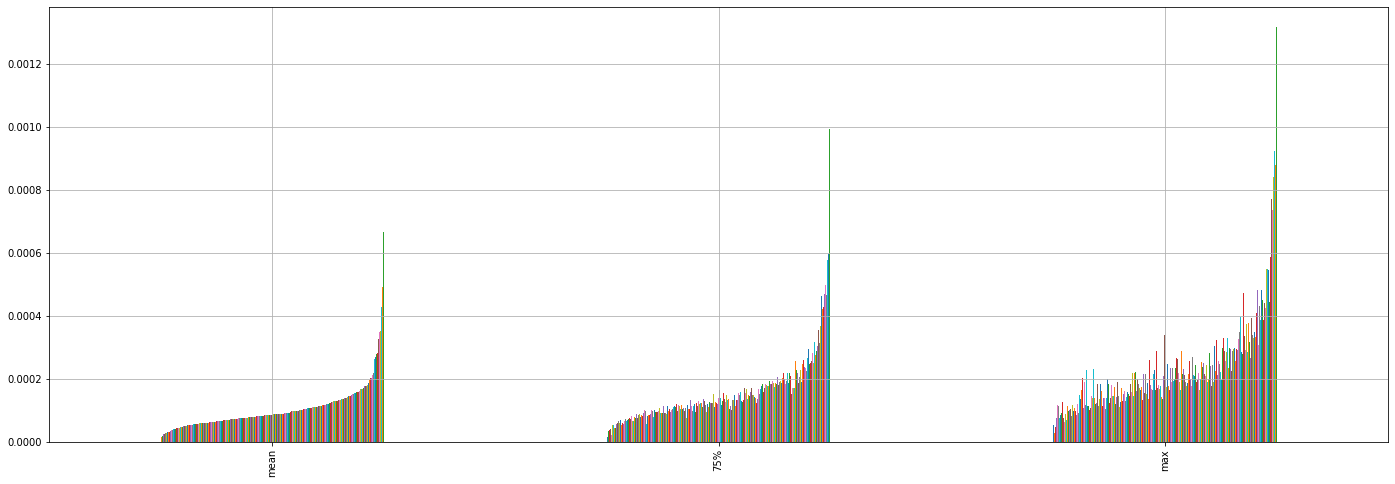

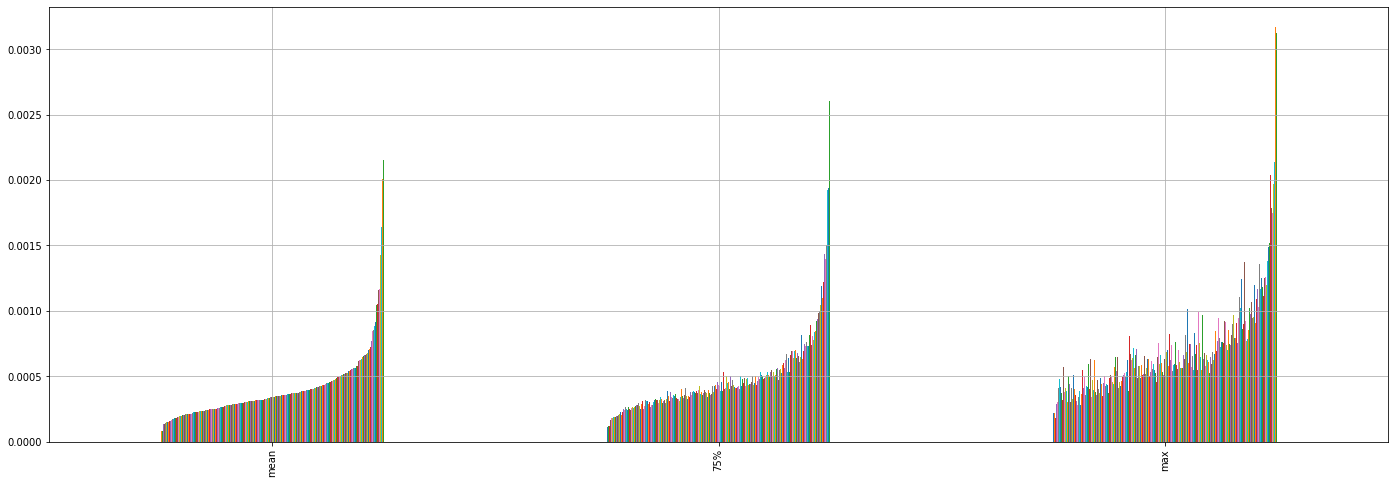

In [159]:
cluster_rels = {}
cluster_metrics = {}

for cluster_label in subcluster_labels:
    
    print("Cluster:", cluster_label)
    tsamples = target_class_features[(pipeline.clusterer.labels_ == cluster_label)]
    tlabels  = target_class_labels[(pipeline.clusterer.labels_ == cluster_label)]
    print("Size:", tlabels.shape[0])
    
    _clustered = pd.DataFrame(pipeline.training_lrp[(pipeline.clusterer.labels_ == cluster_label)],
                              columns = train_data.columns)
#   
    _metrics = _clustered.describe().loc[["mean","75%","max"]]
    srtd_metrics = _metrics.sort_values(by=["mean", "75%", "max"], axis=1)
    srtd_metrics.plot(kind="bar", figsize=(24,8), legend=False, grid=True)
    
    cluster_metrics[cluster_label] = _metrics.T
    cluster_rels[cluster_label] = _clustered

## Individual metric histograms for each cluster

In [160]:
cluster_metrics[0]["mean"].std()

7.125993152312914e-05

Text(0.5, 0, 'Relevances')

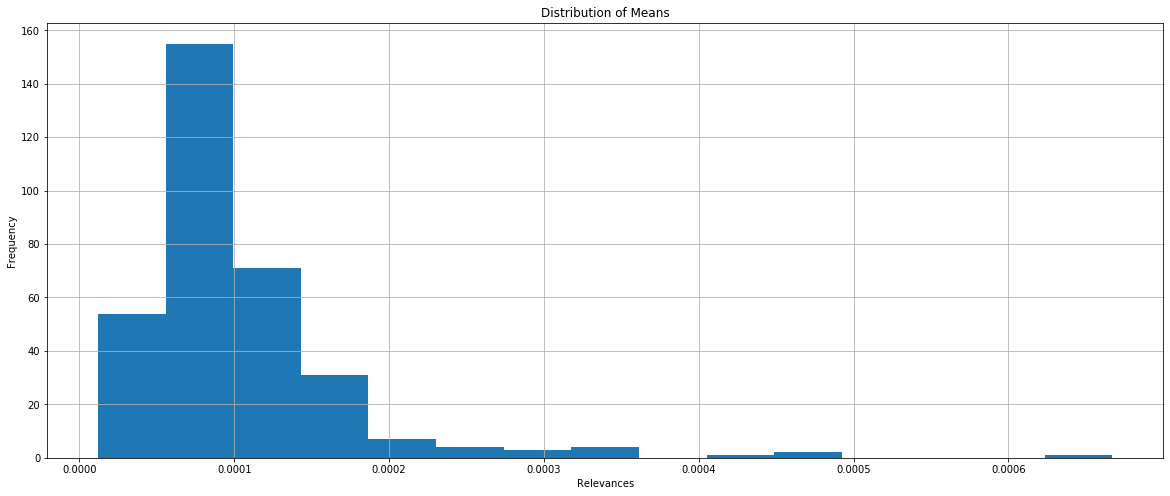

In [161]:
# Looks like (exponential) pareto...

ax = cluster_metrics[0]["mean"].plot(kind="hist", figsize=(20,8), bins=15, grid=True, title="Distribution of Means") 
ax.set_xlabel("Relevances")

Text(0.5, 0, 'Relevances')

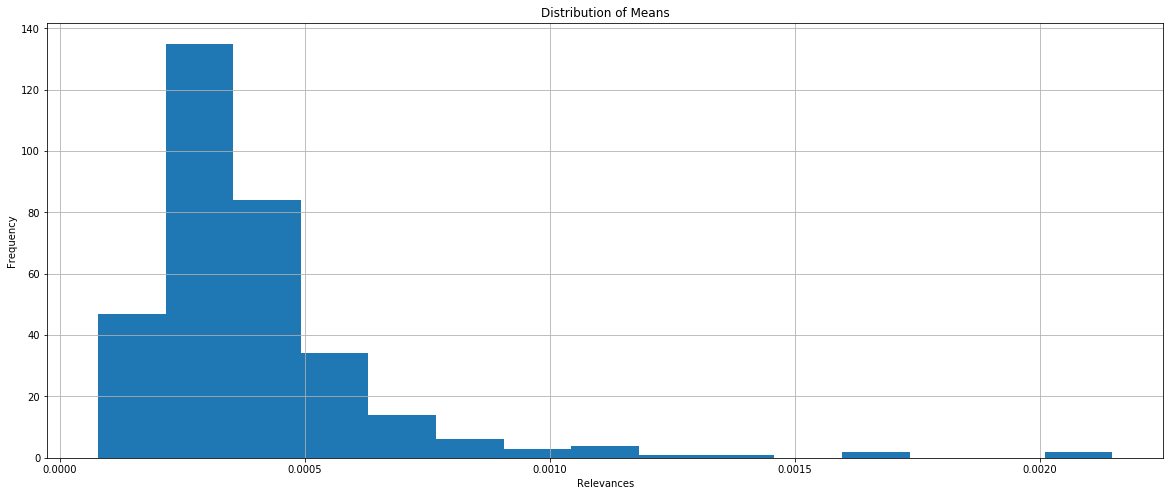

In [151]:
ax = cluster_metrics[1]["mean"].plot(kind="hist", figsize=(20,8), bins=15, grid=True, title="Distribution of Means") 
ax.set_xlabel("Relevances")

In [170]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.7) <= thresh)

    criteria = max_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

In [182]:
for cluster_label in subcluster_labels:

    thresh = cluster_metrics[cluster_label]["mean"].mean() + 3*cluster_metrics[0]["mean"].std()
#     thresh = _clustered.quantile(0.8).quantile(0.5)
    print("Thresh:", thresh)
    reduced_cols = get_relevant_cols(cluster_rels[cluster_label], thresh=thresh).columns
    print(reduced_cols, len(reduced_cols))

Thresh: 0.0003168120023466077
Index(['ROI14', 'ROI15', 'ROI38', 'ROI44', 'ROI45', 'ROI48', 'ROI49', 'ROI50',
       'ROI56', 'ROI63', 'ROI79', 'ROI80', 'ROI87', 'ROI90', 'ROI93', 'ROI120',
       'ROI127', 'ROI131', 'ROI139', 'ROI150', 'ROI154', 'ROI166', 'ROI171',
       'ROI175', 'ROI178', 'ROI185', 'ROI196', 'ROI197', 'ROI198', 'ROI200',
       'ROI202', 'ROI208', 'ROI224', 'ROI230', 'ROI233', 'ROI239', 'ROI251',
       'ROI252', 'ROI262', 'ROI268', 'ROI270', 'ROI271', 'ROI273', 'ROI274',
       'ROI277', 'ROI280', 'ROI281', 'ROI283', 'ROI284', 'ROI285', 'ROI288',
       'ROI306', 'ROI332', 'ROI333'],
      dtype='object') 54
Thresh: 0.0006104652520604642
Index(['ROI05', 'ROI06', 'ROI07', 'ROI08', 'ROI11', 'ROI12', 'ROI13', 'ROI14',
       'ROI15', 'ROI17',
       ...
       'ROI319', 'ROI321', 'ROI322', 'ROI325', 'ROI326', 'ROI327', 'ROI328',
       'ROI330', 'ROI332', 'ROI333'],
      dtype='object', length=166) 166
